In [5]:
import numpy as np 
import torch 
import torch.nn as nn
import gym 
import matplotlib.pyplot as plt
from torch.autograd import Variable

from Visualisation import render_averages_plot, render_plot_with_hist

# define the model 

class DQN():

    def __init__(self, state_dim, action_dim, lr):
        super(DQN, self).__init__()
        SIZE = 64

        self.nn = nn.Sequential(
                torch.nn.Linear(state_dim, SIZE),
                nn.LeakyReLU(),
                nn.Linear(SIZE, SIZE * 2),
                nn.LeakyReLU(),
                nn.Linear(SIZE * 2, action_dim)
        )

        self.loss = nn.MSELoss()
        self.optimiser = torch.optim.Adam(self.nn.parameters(), lr)


    def update(self, state, y):
        y_pred = self.nn(torch.Tensor(state))
        loss = self.loss(y_pred, Variable(torch.Tensor(y)))
        # print(loss.item())
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        return y_pred, loss.item()
        


    def predict(self, state):
        with torch.no_grad():
            return self.nn(torch.Tensor(state))

In [150]:

def train(env, model, episodes, gamma, epsilon, decay):


    final_reward = []
    goal_achieved = 0   
    episode_num = 0
    average_loss_per_ep = []
    act_q_0 = []
    act_q_1 = []
    pred_q_0 = []
    pred_q_1 = []
    

    for _ in range(episodes):
        loss_ep = []
        
        episode_num +=1
        state = env.reset()
        done = False
        total = 0

        while not done:
            q_values = model.predict(state)
            if np.random.random() < epsilon:
                action = env.action_space.sample()
            else:
                action = torch.argmax(q_values).item()

            next_state, reward, done, _ = env.step(action)
            #env.render()
            total += reward

            if done:
                q_values[action] = reward
                y_pred, loss = model.update(state, q_values)
                loss_ep.append(loss)
                break 

            q_values_next = model.predict(next_state)
            # print(q_values_next)
            q_values[action] = reward + gamma * torch.max(q_values_next).item()
            # print(q_values)
            act_q, loss = model.update(state, q_values)
            
            
            print("Next", q_values_next)
            
            
            act_q_0.append(act_q[0].item())
            act_q_1.append(act_q[1].item())
            
            pred_q_0.append(q_values_next[0].item())
            pred_q_1.append(q_values_next[1].item())
            
            loss_ep.append(loss)
            state = next_state
    
        epsilon = max(epsilon * decay, 0.01)
        final_reward.append(total)
        avg_loss = np.mean(loss_ep)
        average_loss_per_ep.append(avg_loss)
        if total >= 200:
            goal_achieved += 1
        print("Episode number:", episode_num, "Reward:", total, "Epsilon:", epsilon)
        # print("Q values", q_values)
        # print("State", state)
        
    print(average_loss_per_ep)
    return final_reward, goal_achieved, average_loss_per_ep, act_q_0, pred_q_0, act_q_1, pred_q_1




In [151]:
def average(runs, env, episodes):
    all_rewards = []
    successes = []

    for _ in range(runs):
        model = DQN(obs_dim, action_dim, lr)
        rewards, goals = train(env, model, episodes, gamma, epsilon, decay)
        all_rewards.append(rewards)
        successes.append(goals)

    
    rewards_array = np.array([np.array(i) for i in all_rewards])
    return rewards_array, successes


In [152]:

# parameters
episodes = 75
lr = 0.001

gamma = 0.9
epsilon = 0.3
decay = 0.99
UPDATE = 10




In [153]:
env = gym.make("CartPole-v1")
obs_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
model = DQN(obs_dim, action_dim, lr)
rewards, goals, mean_loss, actual_0, predicted_0, actual_1, predicted_1 = train(env, model, episodes, gamma, epsilon, decay)


Next tensor([ 0.1548, -0.1055])
Next tensor([ 0.1509, -0.0425])
Next tensor([0.1719, 0.0049])
Next tensor([0.2028, 0.0383])
Next tensor([0.2353, 0.0527])
Next tensor([0.2850, 0.0679])
Next tensor([0.3515, 0.0777])
Next tensor([0.4368, 0.0858])
Next tensor([0.5443, 0.0950])
Next tensor([0.6757, 0.1079])
Episode number: 1 Reward: 11.0 Epsilon: 0.297
Next tensor([0.4776, 0.0792])
Next tensor([0.4954, 0.0581])
Next tensor([0.5447, 0.0952])
Next tensor([0.6204, 0.1284])
Next tensor([0.7246, 0.1562])
Next tensor([0.8568, 0.1795])
Next tensor([1.0143, 0.2046])
Next tensor([1.2017, 0.2353])
Next tensor([1.4168, 0.2706])
Next tensor([1.6672, 0.3089])
Next tensor([1.9577, 0.3556])
Episode number: 2 Reward: 12.0 Epsilon: 0.29402999999999996
Next tensor([0.9782, 0.1971])
Next tensor([1.1219, 0.2347])
Next tensor([1.3068, 0.2690])
Next tensor([1.5210, 0.3040])
Next tensor([1.7700, 0.3415])
Next tensor([2.0544, 0.3867])
Next tensor([2.3783, 0.4363])
Next tensor([2.3245, 0.4149])
Episode number: 3 Re

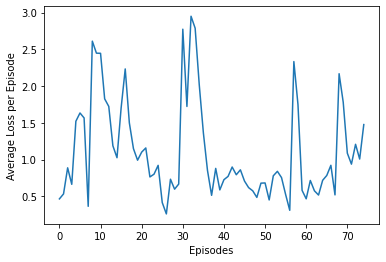

In [154]:
plt.plot(range(episodes), mean_loss)
plt.xlabel("Episodes")
plt.ylabel("Average Loss per Episode")
plt.show()

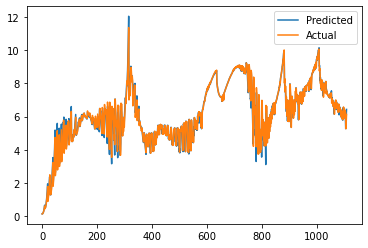

In [155]:
plt.plot(predicted_0, label="Predicted")
plt.plot(actual_0, label="Actual")

# plt.plot(actual_1)
# plt.plot(predicted_1)
plt.legend()
plt.show()

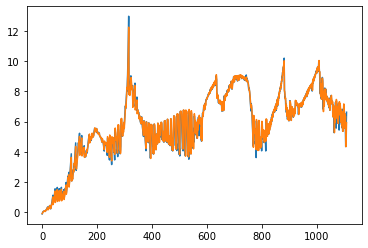

In [157]:
plt.plot(predicted_1, label="Predicted")
plt.plot(actual_1, label="Actual")
plt.show()

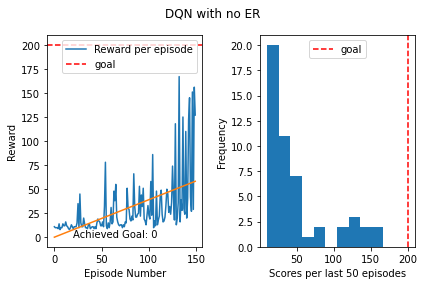

In [13]:
render_plot_with_hist(range(episodes), rewards, goals, "DQN with no ER", True, "SRHist")

In [8]:
rewards, goals = average(3, env, episodes)

Episode number: 1 Reward: 13.0 Epsilon: 0.297
Episode number: 2 Reward: 12.0 Epsilon: 0.29402999999999996
Episode number: 3 Reward: 11.0 Epsilon: 0.29108969999999995
Episode number: 4 Reward: 11.0 Epsilon: 0.28817880299999993
Episode number: 5 Reward: 15.0 Epsilon: 0.28529701496999993
Episode number: 6 Reward: 15.0 Epsilon: 0.28244404482029994
Episode number: 7 Reward: 10.0 Epsilon: 0.27961960437209693
Episode number: 8 Reward: 10.0 Epsilon: 0.276823408328376
Episode number: 9 Reward: 10.0 Epsilon: 0.27405517424509224
Episode number: 10 Reward: 12.0 Epsilon: 0.2713146225026413
Episode number: 11 Reward: 14.0 Epsilon: 0.2686014762776149
Episode number: 12 Reward: 11.0 Epsilon: 0.26591546151483875
Episode number: 13 Reward: 14.0 Epsilon: 0.2632563068996904
Episode number: 14 Reward: 11.0 Epsilon: 0.2606237438306935
Episode number: 15 Reward: 14.0 Epsilon: 0.2580175063923865
Episode number: 16 Reward: 11.0 Epsilon: 0.25543733132846264
Episode number: 17 Reward: 11.0 Epsilon: 0.25288295801

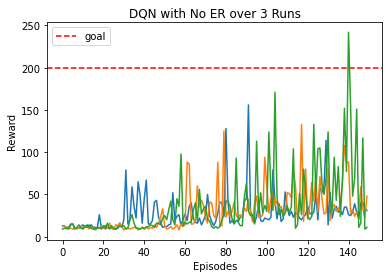

In [9]:
render_averages_plot(range(episodes), rewards, "DQN with No ER over 3 Runs", "SR3")

In [10]:
print(goals)
print(np.average(goals))

[0, 0, 1]
0.3333333333333333
